<a href="https://colab.research.google.com/github/joanfco30/CocoaMoniliaDataSet/blob/main/CocoaMoniliaDataSet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CocoaMoniliaDataSet: A cocoa pod dataset to detect and classify Monilia roreri in real conditions

In [1]:
from pathlib import Path
import shutil
import os, random, glob
import cv2 as cv
import matplotlib.pyplot as plt
import random
from pycocotools.coco import COCO
import json
import time
import pandas as pd
import numpy as np
%matplotlib inline

# Crear un repo de la siguiente manera



1.   Descargar el dataset
2.   Descomprimir el dataset
3.   Split the dataset (Yolo BBX o Seg)
4.   El yml para YOLO



In [2]:
 !wget -O dataset.zip "https://zenodo.org/records/17156052/files/CocoaMoniliaDataSet.zip?download=1"

--2025-11-21 19:10:56--  https://zenodo.org/records/17156052/files/CocoaMoniliaDataSet.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.153, 137.138.52.235, 188.185.48.75, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6187303002 (5.8G) [application/octet-stream]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]   5.76G  24.6MB/s    in 4m 29s  

2025-11-21 19:15:25 (22.0 MB/s) - ‘dataset.zip’ saved [6187303002/6187303002]



In [3]:
!unzip dataset.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: CocoaMoniliaDataSet/mask_segmentation/SegmentationClassm1/IMG_20240229_001716_5.png  
  inflating: CocoaMoniliaDataSet/mask_segmentation/SegmentationClassm1/IMG_20240229_002631_7.png  
  inflating: CocoaMoniliaDataSet/mask_segmentation/SegmentationClassm1/IMG_20240229_002635_3.png  
  inflating: CocoaMoniliaDataSet/mask_segmentation/SegmentationClassm1/IMG_20240229_002641_7.png  
  inflating: CocoaMoniliaDataSet/mask_segmentation/SegmentationClassm1/IMG_20240229_002643_9.png  
  inflating: CocoaMoniliaDataSet/mask_segmentation/SegmentationClassm1/IMG_20240229_003921_874.png  
  inflating: CocoaMoniliaDataSet/mask_segmentation/SegmentationClassm1/IMG_20240229_003925_198.png  
  inflating: CocoaMoniliaDataSet/mask_segmentation/SegmentationClassm1/IMG_20240229_003927_582.png  
  inflating: CocoaMoniliaDataSet/mask_segmentation/SegmentationClassm1/IMG_20240229_003930_804.png  
  inflating: CocoaMoniliaDataSet/mask_se

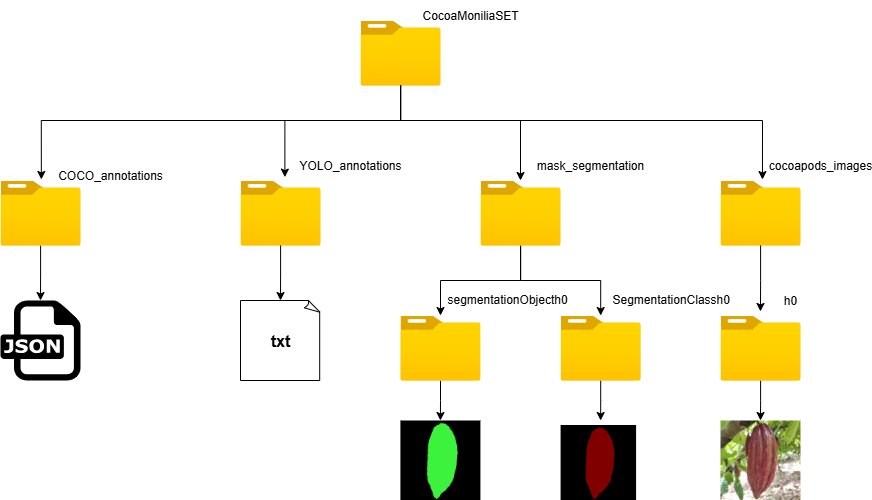



```
CocoaMoniliaDataSet/
│
├── cocoapods_images/
│     ├── h0/
│     ├── m1/
│     ├── m2/
│     ├── m3/
│
│── COCO_annotations/
│     ├── instances_h0.json
│     ├── instances_m1.json
│     ├── instances_m2.json
│     ├── instances_m3.json
│
│── mask_segmentation/
│     ├── SegmentationClassh0/
│     ├── segmentationObjecth0/
│     ├── SegmentationClassm1/
│     ├── segmentationObjectm1/
│     ├── SegmentationClassm2/
│     ├── segmentationObjectm2/
│     ├── SegmentationClassm3/
│     ├── segmentationObjectm3/
│  
│── YOLO_annotations/
      ├── h0/
      ├── m1/
      ├── m2/
      ├── m3/


```



## Method to split the dataset YOLO Segmentation format





```
│── DataSet_split_seg/
│     ├─ images/
│     │    ├── train/
│     │    ├── test/
│     │    ├── val/
│     │
│     │
│     ├─ labels/
           ├── train/
           ├── test/
           ├── val/
```






In [4]:
cocoa_img_directory = Path("/content/CocoaMoniliaDataSet/cocoapods_images")
label_img_directory = Path("/content/CocoaMoniliaDataSet/COCO_annotations")

In [5]:
# Image directory dict

img_dirs_dict = {d.name:
                 d for d in cocoa_img_directory.iterdir()
}
# Label jason files dict
label_files = {
    f.stem.replace("instances_", ""): f
    for f in label_img_directory.iterdir()
    if f.is_file() and f.suffix == ".json"
}
for cls in sorted(img_dirs_dict.keys()):

  # === Input and output paths ===
    coco_json_path = str(label_files.get(cls))       # your JSON file
    output_dir = str(img_dirs_dict[cls])             # folder for YOLO txts
    #os.makedirs(output_dir, exist_ok=True)

    # === Load COCO annotations ===
    with open(coco_json_path, "r") as f:
        coco = json.load(f)

    # Create helper maps
    images = {img["id"]: img for img in coco["images"]}
    categories = {cat["id"]: cat["name"] for cat in coco["categories"]}

    # === Iterate over annotations ===
    for ann in coco["annotations"]:
        image_id = ann["image_id"]
        cat_id = ann["category_id"]
        segmentation = ann["segmentation"]

        # Get image details
        image_info = images[image_id]
        img_w, img_h = image_info["width"], image_info["height"]

        # Each annotation can have multiple segmentations (use all)
        yolo_lines = []
        if isinstance(segmentation, list):
            for seg in segmentation:
                if len(seg) < 6:
                    continue  # invalid polygon
                # Normalize coordinates
                norm_coords = []
                for i in range(0, len(seg), 2):
                    x = seg[i] / img_w
                    y = seg[i + 1] / img_h
                    norm_coords.append(f"{x:.6f} {y:.6f}")

                line = f"{cat_id - 1} " + " ".join(norm_coords)  # YOLO class ids start at 0
                yolo_lines.append(line)

        # === Write output file ===
        txt_path = os.path.join(output_dir, os.path.splitext(image_info["file_name"])[0] + ".txt")
        with open(txt_path, "a") as f:
            for line in yolo_lines:
                f.write(line + "\n")

    print(f"✅ Conversion complete! YOLO txt labels saved to: {output_dir}")

✅ Conversion complete! YOLO txt labels saved to: /content/CocoaMoniliaDataSet/cocoapods_images/h0
✅ Conversion complete! YOLO txt labels saved to: /content/CocoaMoniliaDataSet/cocoapods_images/m1
✅ Conversion complete! YOLO txt labels saved to: /content/CocoaMoniliaDataSet/cocoapods_images/m2
✅ Conversion complete! YOLO txt labels saved to: /content/CocoaMoniliaDataSet/cocoapods_images/m3


## Method to split the dataset YOLO format

```
│── DataSet_split_seg/
│     ├─ images/
│     │    ├── train/
│     │    ├── test/
│     │    ├── val/
│     │
│     │
│     ├─ labels/
           ├── train/
           ├── test/
           ├── val/
```

In [6]:
# We create a subdirectory to split the dataset
DATA_ROOT = Path("/content/CocoaMoniliaDataSet/cocoapods_images")

#In the output directory, we split the dataset into train, validation, and test

WORK_DIR  = Path("/content/DataSet_split_seg")
print(DATA_ROOT, WORK_DIR)
# Create YOLO structure to separate the labels and the images in each directory
for split in ["train", "val", "test"]:
    (WORK_DIR / f"images/{split}").mkdir(parents=True, exist_ok=True)
    (WORK_DIR / f"labels/{split}").mkdir(parents=True, exist_ok=True)

/content/CocoaMoniliaDataSet/cocoapods_images /content/DataSet_split_seg


In [7]:
img_exts = {".jpg", ".jpeg", ".png"}
pairs = []

for img_path in DATA_ROOT.rglob("*"):
    if img_path.suffix.lower() in img_exts:
        label_path = img_path.with_suffix(".txt")
        if label_path.exists():
            pairs.append((img_path, label_path))

print(f"Found {len(pairs)} image-label pairs.")

# Shuffle & split
random.shuffle(pairs)
n = len(pairs)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
splits = {
    "train": pairs[:n_train],
    "val": pairs[n_train:n_train+n_val],
    "test": pairs[n_train+n_val:]
}
# Copy files into YOLO structure
for split, items in splits.items():
    for img, lbl in items:
        shutil.copy2(img, WORK_DIR / f"images/{split}/{img.name}")
        shutil.copy2(lbl, WORK_DIR / f"labels/{split}/{lbl.name}")

print({k: len(v) for k,v in splits.items()})

Found 1950 image-label pairs.
{'train': 1560, 'val': 195, 'test': 195}


## Method to create a Yolo object detection format




In [31]:
for file in cocoa_img_directory.iterdir():
  for filename in os.listdir(file):
    if filename.endswith(".txt"):
        file_path = os.path.join(file, filename)

        os.remove(file_path)

  print(f"✅ Deleting YOLO txt complete in {file}")

✅ Deleting YOLO txt complete in /content/CocoaMoniliaDataSet/cocoapods_images/m1
✅ Deleting YOLO txt complete in /content/CocoaMoniliaDataSet/cocoapods_images/h0
✅ Deleting YOLO txt complete in /content/CocoaMoniliaDataSet/cocoapods_images/m3
✅ Deleting YOLO txt complete in /content/CocoaMoniliaDataSet/cocoapods_images/m2


In [14]:
# Image directory dict

img_dirs_dict = {d.name:
                 d for d in cocoa_img_directory.iterdir()
}
# Label jason files dict
label_files = {
    f.stem.replace("instances_", ""): f
    for f in label_img_directory.iterdir()
    if f.is_file() and f.suffix == ".json"
}
for cls in sorted(img_dirs_dict.keys()):

  # === Input and output paths ===
    coco_json_path = str(label_files.get(cls))       # your JSON file
    output_dir = str(img_dirs_dict[cls])             # folder for YOLO txts
    #os.makedirs(output_dir, exist_ok=True)

    # === Load COCO annotations ===
    with open(coco_json_path, "r") as f:
        coco = json.load(f)

    # Create helper maps
    images = {img["id"]: img for img in coco["images"]}
    categories = {cat["id"]: cat["name"] for cat in coco["categories"]}

    # === Iterate over annotations ===
    for ann in coco["annotations"]:
        image_id = ann["image_id"]
        cat_id = ann["category_id"]
        bbox  = ann["bbox"]

        # COCO bbox = [x_min, y_min, width, height]
        x_min, y_min, w_box, h_box = bbox

        # Get image details
        image_info = images[image_id]
        img_w, img_h = image_info["width"], image_info["height"]

        # === Convert COCO → YOLO format ===
        # YOLO bbox = [cx, cy, w, h] normalized
        cx = (x_min + w_box / 2) / img_w
        cy = (y_min + h_box / 2) / img_h
        w_norm = w_box / img_w
        h_norm = h_box / img_h

        # YOLO class index starts at 0, but COCO starts at 1
        yolo_line = f"{cat_id - 1} {cx:.6f} {cy:.6f} {w_norm:.6f} {h_norm:.6f}"


        # === Write output file ===
        txt_path = os.path.join(output_dir, os.path.splitext(image_info["file_name"])[0] + ".txt")
        with open(txt_path, "a") as f:
          f.write(yolo_line + "\n")

    print(f"✅ Conversion complete! YOLO txt labels saved to: {output_dir}")

✅ Conversion complete! YOLO txt labels saved to: /content/CocoaMoniliaDataSet/cocoapods_images/h0
✅ Conversion complete! YOLO txt labels saved to: /content/CocoaMoniliaDataSet/cocoapods_images/m1
✅ Conversion complete! YOLO txt labels saved to: /content/CocoaMoniliaDataSet/cocoapods_images/m2
✅ Conversion complete! YOLO txt labels saved to: /content/CocoaMoniliaDataSet/cocoapods_images/m3


In [15]:
WORK_DIR  = Path("/content/DataSet_split_bbox")
print(DATA_ROOT, WORK_DIR)
# Create YOLO structure to separate the labels and the images in each directory
for split in ["train", "val", "test"]:
    (WORK_DIR / f"images/{split}").mkdir(parents=True, exist_ok=True)
    (WORK_DIR / f"labels/{split}").mkdir(parents=True, exist_ok=True)

/content/CocoaMoniliaDataSet/cocoapods_images /content/DataSet_split_bbox


In [16]:
img_exts = {".jpg", ".jpeg", ".png"}
pairs = []

for img_path in DATA_ROOT.rglob("*"):
    if img_path.suffix.lower() in img_exts:
        label_path = img_path.with_suffix(".txt")
        if label_path.exists():
            pairs.append((img_path, label_path))

print(f"Found {len(pairs)} image-label pairs.")

# Shuffle & split
random.shuffle(pairs)
n = len(pairs)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
splits = {
    "train": pairs[:n_train],
    "val": pairs[n_train:n_train+n_val],
    "test": pairs[n_train+n_val:]
}
# Copy files into YOLO structure
for split, items in splits.items():
    for img, lbl in items:
        shutil.copy2(img, WORK_DIR / f"images/{split}/{img.name}")
        shutil.copy2(lbl, WORK_DIR / f"labels/{split}/{lbl.name}")

print({k: len(v) for k,v in splits.items()})

Found 1950 image-label pairs.
{'train': 1560, 'val': 195, 'test': 195}


In [ ]:
#!zip -r /content/CocoaMoniliaDataSet_split.zip /content/CocoaMoniliaDataSet_split

In [ ]:
#from google.colab import files
#files.download("/content/file.zip")

In [32]:
images_dir = "/content/CocoaMoniliaDataSet/cocoapods_images/m3"                # Folder with your .jpg images
labels_dir = "/content/CocoaMoniliaDataSet/cocoapods_images/m3"       # Folder with your YOLO segmentation .txt files
class_names = ["h0", "m1", "m2", "m3"]

visualize_one_yolo_segmentation(images_dir, labels_dir, class_names)

⚠️ Label file not found for IMG_20240802_125323.jpg


In [ ]:
# We create a subdirectory to split the dataset
DATA_ROOT = Path("/content/CocoaMoniliaDataSet/cocoapods_images")

#In the output directory, we split the dataset into train, validation, and test

WORK_DIR  = Path("/content/CocoaMoniliaDataSet/DataSet_split_seg")
print(DATA_ROOT, WORK_DIR)
# Create YOLO structure to separate the labels and the images in each directory
for split in ["train", "val", "test"]:
    (WORK_DIR / f"images/{split}").mkdir(parents=True, exist_ok=True)
    (WORK_DIR / f"labels/{split}").mkdir(parents=True, exist_ok=True)

/content/CocoaMoniliaDataSet/cocoapods_images /content/CocoaMoniliaDataSet/DataSet_split_seg


In [ ]:
img_exts = {".jpg", ".jpeg", ".png"}
pairs = []

for img_path in DATA_ROOT.rglob("*"):
    if img_path.suffix.lower() in img_exts:
        label_path = img_path.with_suffix(".txt")
        if label_path.exists():
            pairs.append((img_path, label_path))

print(f"Found {len(pairs)} image-label pairs.")

# Shuffle & split
random.shuffle(pairs)
n = len(pairs)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
splits = {
    "train": pairs[:n_train],
    "val": pairs[n_train:n_train+n_val],
    "test": pairs[n_train+n_val:]
}
# Copy files into YOLO structure
for split, items in splits.items():
    for img, lbl in items:
        shutil.copy2(img, WORK_DIR / f"images/{split}/{img.name}")
        shutil.copy2(lbl, WORK_DIR / f"labels/{split}/{lbl.name}")

print({k: len(v) for k,v in splits.items()})

Found 1950 image-label pairs.
{'train': 1560, 'val': 195, 'test': 195}


In [ ]:
!zip -r /content/DataSet_split_seg.zip /content/CocoaMoniliaDataSet/DataSet_split_seg

  adding: content/CocoaMoniliaDataSet/DataSet_split_seg/ (stored 0%)
  adding: content/CocoaMoniliaDataSet/DataSet_split_seg/labels/ (stored 0%)
  adding: content/CocoaMoniliaDataSet/DataSet_split_seg/labels/val/ (stored 0%)
  adding: content/CocoaMoniliaDataSet/DataSet_split_seg/labels/val/IMG_20240226_152902600_HDR.txt (deflated 58%)
  adding: content/CocoaMoniliaDataSet/DataSet_split_seg/labels/val/IMG_20240229_000505_595.txt (deflated 57%)
  adding: content/CocoaMoniliaDataSet/DataSet_split_seg/labels/val/1728667862709.txt (deflated 63%)
  adding: content/CocoaMoniliaDataSet/DataSet_split_seg/labels/val/IMG_20240928_102659624_HDR.txt (deflated 59%)
  adding: content/CocoaMoniliaDataSet/DataSet_split_seg/labels/val/1728667862670.txt (deflated 61%)
  adding: content/CocoaMoniliaDataSet/DataSet_split_seg/labels/val/IMG_20240229_003525_339.txt (deflated 58%)
  adding: content/CocoaMoniliaDataSet/DataSet_split_seg/labels/val/20241011_112930.txt (deflated 58%)
  adding: content/CocoaMoni

In [ ]:
#from google.colab import files
#files.download("/content/DataSet_split_seg.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:


#!zip -r /content/DataSet_split_bbox.zip /content/CocoaMoniliaDataSet/DataSet_split_bbox


#from google.colab import files
#files.download("/content/DataSet_split_bbox.zip")

In [20]:
import os
import cv2 as cv
import numpy as np
import random
import matplotlib.pyplot as plt

def visualize_one_yolo_segmentation(
    images_dir,
    labels_dir,
    class_names=None,
    image_name=None,
    resize=800
):
    # -------------------------------------------------------
    # 1. Pick random image if image_name not provided
    # -------------------------------------------------------
    image_files = [f for f in os.listdir(images_dir)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if len(image_files) == 0:
        raise ValueError("No image files found in images_dir!")

    if image_name is None:
        image_name = random.choice(image_files)

    img_path = os.path.join(images_dir, image_name)
    label_name = os.path.splitext(image_name)[0] + ".txt"
    label_path = os.path.join(labels_dir, label_name)

    # -------------------------------------------------------
    # 2. Load image
    # -------------------------------------------------------
    img = cv.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {img_path}")

    orig_h, orig_w, _ = img.shape

    # Resize for display
    scale = resize / max(orig_h, orig_w)
    if scale < 1:
        img = cv.resize(img, (int(orig_w * scale), int(orig_h * scale)))
    h, w, _ = img.shape

    # -------------------------------------------------------
    # 3. Check label file
    # -------------------------------------------------------
    if not os.path.exists(label_path):
        print(f"⚠️ Label file not found for {image_name}")
        return

    # -------------------------------------------------------
    # 4. Draw segmentation polygon + bounding box
    # -------------------------------------------------------
    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()

            if len(parts) < 7:
                continue  # Not enough points for polygon

            cls_id = int(parts[0])
            coords = np.array(list(map(float, parts[1:])), dtype=np.float32).reshape(-1, 2)

            # Scale polygon to resized image
            coords[:, 0] *= w
            coords[:, 1] *= h
            pts = coords.astype(np.int32)

            # ---- Draw segmentation polygon ----
            cv.polylines(img, [pts], isClosed=True, color=(0, 255, 0), thickness=2)

            # ---- Compute bounding box ----
            x_min, y_min = np.min(pts[:, 0]), np.min(pts[:, 1])
            x_max, y_max = np.max(pts[:, 0]), np.max(pts[:, 1])

            cv.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

            # ---- Add label ----
            class_label = (
                class_names[cls_id]
                if class_names and cls_id < len(class_names)
                else f"class_{cls_id}"
            )
            cv.putText(img, class_label, (x_min, y_min - 5),
                       cv.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    # -------------------------------------------------------
    # 5. Display image (Matplotlib)
    # -------------------------------------------------------
    plt.figure(figsize=(8, 8))
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.title(f"YOLO Seg + BBox: {image_name}")
    plt.axis("off")
    plt.show()


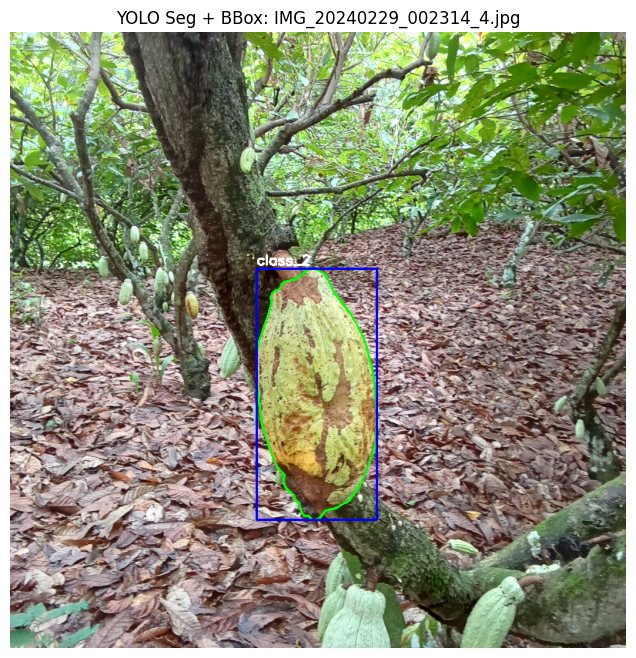

In [33]:
images_dir = "/content/DataSet_split_seg/images/train"                # Folder with your .jpg images
labels_dir = "/content/DataSet_split_seg/labels/train"       # Folder with your YOLO segmentation .txt files
visualize_one_yolo_segmentation(images_dir, labels_dir)

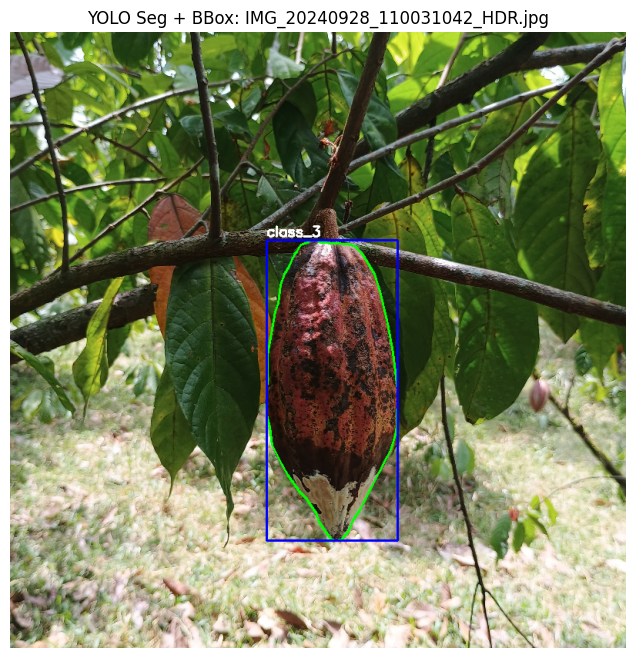

In [22]:
images_dir = "/content/DataSet_split_seg/images/test"                # Folder with your .jpg images
labels_dir = "/content/DataSet_split_seg/labels/test"       # Folder with your YOLO segmentation .txt files
visualize_one_yolo_segmentation(images_dir, labels_dir)

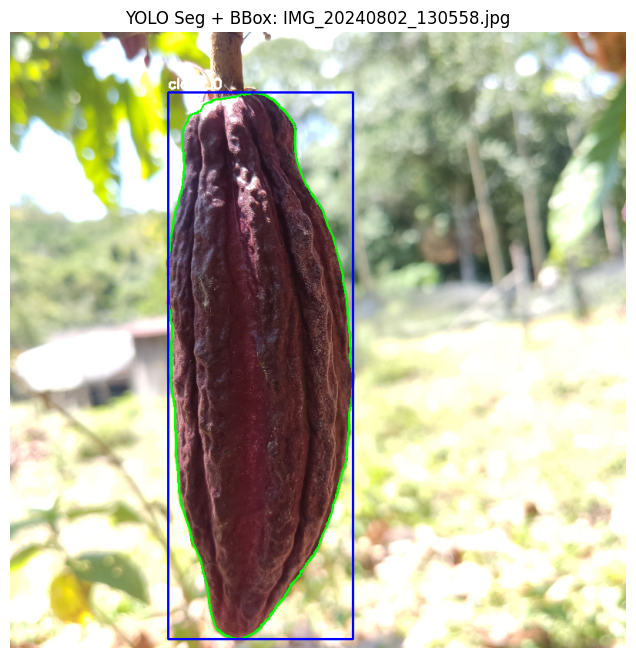

In [25]:
images_dir = "/content/DataSet_split_seg/images/val"                # Folder with your .jpg images
labels_dir = "/content/DataSet_split_seg/labels/val"       # Folder with your YOLO segmentation .txt files
visualize_one_yolo_segmentation(images_dir, labels_dir)